# Keep-it-dry! GaussianNB

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

from pprint import pprint

## Dataset Selection

In [3]:
datasets_dict = {}

datasets_dict['ii_mm_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_adasyn.csv', index_col=0)
datasets_dict['ii_mm_ros'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_ros.csv', index_col=0)
datasets_dict['ii_mm_rus'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_rus.csv', index_col=0)
datasets_dict['ii_mm_smote'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_smote.csv', index_col=0)
datasets_dict['ii_mm_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ii_mm_smotenc_1.csv', index_col=0)

datasets_dict['ii_ro_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_adasyn.csv', index_col=0)
datasets_dict['ii_ro_ros'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_ros.csv', index_col=0)
datasets_dict['ii_ro_rus'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_rus.csv', index_col=0)
datasets_dict['ii_ro_smote'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_smote.csv', index_col=0)
datasets_dict['ii_ro_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ii_ro_smotenc_1.csv', index_col=0)

datasets_dict['ii_st_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_adasyn.csv', index_col=0)
datasets_dict['ii_st_ros'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_ros.csv', index_col=0)
datasets_dict['ii_st_rus'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_rus.csv', index_col=0)
datasets_dict['ii_st_smote'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_smote.csv', index_col=0)
datasets_dict['ii_st_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ii_st_smotenc_1.csv', index_col=0)

datasets_dict['ki_mm_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_adasyn.csv', index_col=0)
datasets_dict['ki_mm_ros'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_ros.csv', index_col=0)
datasets_dict['ki_mm_rus'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_rus.csv', index_col=0)
datasets_dict['ki_mm_smote'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_smote.csv', index_col=0)
datasets_dict['ki_mm_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ki_mm_smotenc_1.csv', index_col=0)

datasets_dict['ki_ro_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_adasyn.csv', index_col=0)
datasets_dict['ki_ro_ros'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_ros.csv', index_col=0)
datasets_dict['ki_ro_rus'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_rus.csv', index_col=0)
datasets_dict['ki_ro_smote'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_smote.csv', index_col=0)
datasets_dict['ki_ro_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ki_ro_smotenc_1.csv', index_col=0)

datasets_dict['ki_st_adasyn'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_adasyn.csv', index_col=0)
datasets_dict['ki_st_ros'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_ros.csv', index_col=0)
datasets_dict['ki_st_rus'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_rus.csv', index_col=0)
datasets_dict['ki_st_smote'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_smote.csv', index_col=0)
datasets_dict['ki_st_smotenc_1'] = pd.read_csv('./../Preprocessing/kid_train_ki_st_smotenc_1.csv', index_col=0)

In [4]:
dataset_result = {}
dataset_result['dataset'] = []
dataset_result['training_accuracy'] = []
dataset_result['testing_accuracy'] = []
dataset_result['testing_f1_score'] = []

for title, data in datasets_dict.items():

    X_df = data.copy()
    y_df = X_df.pop('failure')
    object_cols = X_df.select_dtypes(include=['object']).columns
    X_df = X_df.drop(object_cols, axis=1)

    X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=.2, stratify=y_df, random_state=42)
    
    gnb_dataset = GaussianNB()
    gnb_dataset.fit(X_train, y_train)
    
    y_predict = gnb_dataset.predict(X_val)

    dataset_result['dataset'].append(title)
    dataset_result['training_accuracy'].append(gnb_dataset.score(X_train, y_train))
    dataset_result['testing_accuracy'].append(gnb_dataset.score(X_val, y_val))
    dataset_result['testing_f1_score'].append(f1_score(y_val, y_predict))

In [5]:
df_result = pd.DataFrame(dataset_result)
df_result_sorted = df_result.sort_values(by='testing_f1_score', ascending=False)

c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\RAYHAN EGAR\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

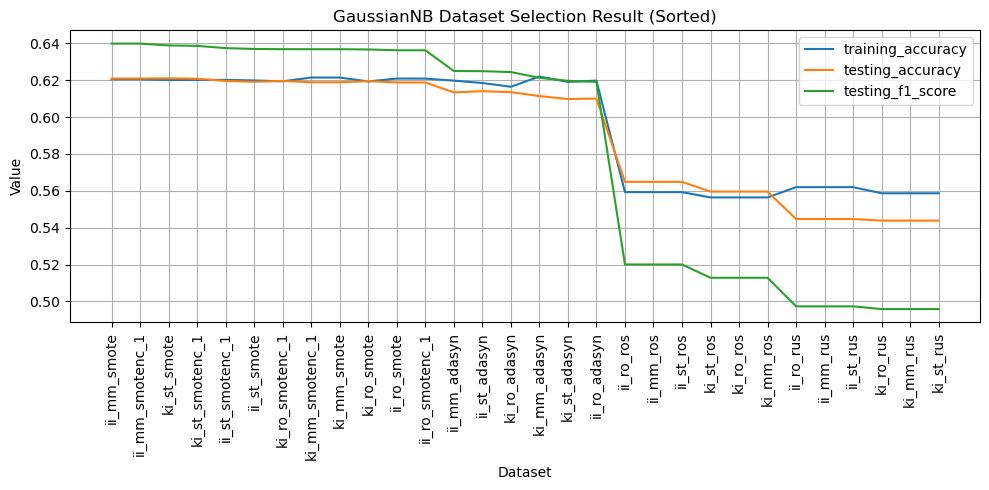

In [6]:
plt.figure(figsize=[10, 5])

sns.lineplot(data=df_result_sorted, x='dataset', y='training_accuracy', label='training_accuracy').grid(True)
sns.lineplot(data=df_result_sorted, x='dataset', y='testing_accuracy', label='testing_accuracy')
sns.lineplot(data=df_result_sorted, x='dataset', y='testing_f1_score', label='testing_f1_score')

plt.title("GaussianNB Dataset Selection Result (Sorted)")
plt.ylabel("Value")
plt.xlabel("Dataset")
plt.xticks(rotation=90)

plt.tight_layout()
plt.legend()
plt.show()

## Data Read

In [8]:
df_train = pd.read_csv('./../Preprocessing/kid_train_ii_ro_ros.csv', index_col=0)
df_test = pd.read_csv('./../Preprocessing/kid_test_ii_ro.csv', index_col=0)

In [9]:
df_test_id = df_test[['id']]

In [10]:
df_test.drop(columns=['id', 'product_code', 'product_code_F', 'product_code_G', 'product_code_H', 'product_code_I'], inplace=True)

In [11]:
# Scale
# Scaled already

In [12]:
X_df = df_train[df_train.columns[:-1]]
y_df = df_train[df_train.columns[-1]]

## PCA

In [13]:
n_components_range = range(10, 23)  # Explore components from 10 to 22

best_n_components = None
best_score = -np.inf  # Initialize with a negative infinity

for n_components in n_components_range:
  # Apply PCA with current n_components
  pca = PCA(n_components=n_components)
  pca_data = pca.fit_transform(X_df)

  # Train RidgeClassifier on transformed data
  model = GaussianNB(var_smoothing=0.001)
  model.fit(pca_data, y_df)

  # Evaluate performance on testing set (e.g., using F1 score)
  score = model.score(pca.transform(X_df), y_df)
  print(f"{n_components} components score: {score}")

  # Update best component and score if performance improves
  if score > best_score:
    best_n_components = n_components
    best_score = score

print("Best number of components based on GaussianNB performance:", best_n_components)

10 components score: 0.5586970030113283
11 components score: 0.5596529802590698
12 components score: 0.5594617848095216
13 components score: 0.5603460637636825
14 components score: 0.5605372592132307
15 components score: 0.5605611586444242
16 components score: 0.5601787677453277
17 components score: 0.5620429233784235
18 components score: 0.561660532479327
19 components score: 0.5618039290664882
20 components score: 0.5613737393050046
21 components score: 0.5617800296352947
22 components score: 0.5618278284976818
Best number of components based on GaussianNB performance: 17


In [14]:
pca = PCA(n_components=17)
X_df_pca = pca.fit_transform(X_df)
df_test_pca = pca.transform(df_test)

## Hyperparameter Tuning using GridSearchCV

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_df_pca, y_df, test_size=.2, random_state=42, stratify=y_df)

In [19]:
# Define model
model = GaussianNB()

# Define hyperparameter grid
param_grid = {
    'var_smoothing': np.logspace(-9, -3, 5)  # Explore different smoothing factors
}

# Define GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='roc_auc')  # Use F1 score

In [20]:
# GridSearchCV fitting
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e-09, 3.16227766e-08, 1.00000000e-06, 3.16227766e-05,
       1.00000000e-03])},
             scoring='roc_auc')

In [22]:
gnb_best = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best f1-score: {grid_search.best_score_}")

Best parameters: {'var_smoothing': 0.001}
Best f1-score: 0.5871728762818468


## Prediction

In [23]:
y_pred = gnb_best.predict(df_test_pca)
y_pred_df = pd.DataFrame(y_pred, columns=['failure'])

In [24]:
y_submission = pd.concat([df_test_id, y_pred_df], axis=1)

In [25]:
y_submission.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,1.0


In [26]:
y_submission.to_csv('./../Submission/kid_submission_gaussiannb_latesub.csv', index=False)

## Kaggle Score
- Private: 0.55729
- Public: 0.55629